In [1]:
## if using Domino's ray, start ray this way

import ray
import os

import ray
import os

if ray.is_initialized() == False:
   service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
   service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
   _temp_dir='/domino/datasets/local/{}/'.format(os.environ['DOMINO_PROJECT_NAME']) #set to a dataset
   ray.util.connect(f"{service_host}:{service_port}")

In [2]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

In [3]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [4]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [6]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio



def create_env(config):
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

In [7]:
#ray.shutdown()
#ray.init()

In [8]:
import os
local_dir = '/domino/datasets/local/{}'.format(os.environ['DOMINO_PROJECT_NAME'])

analysis = tune.run(
    "DQN",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "INFO",#original DEBUG
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 3,  ##adjust number of workers
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter"
    },
    checkpoint_at_end=True,
    checkpoint_freq = 1,
    local_dir = local_dir
)

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:48:29 (running for 00:00:00.15)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 0/35 CPUs, 0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 PENDING)
(run pid=3991) +----------------------------+----------+-------+
(run pid=3991) | Trial name                 | status   | loc   |
(run pid=3991) |----------------------------+----------+-------|
(run pid=3991) | DQN_TradingEnv_eb0ad_00000 | PENDING  |       |
(run pid=3991) +----------------------------+----------+-------+
(run pid=3991) 
(run pid=3991) 


(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:34,352	INFO dqn.py:141 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=1620, ip=10.0.38.75) 2021-12-17 18:48:38,331	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=1620, ip=10.0.38.75) 2021-12-17 18:48:38,365	INFO torch_policy.py:162 -- TorchPolicy (worker=1) running on CPU.
(RolloutWorker pid=1620, ip=10.0.38.75) 2021-12-17 18:48:38,547	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:38,736	INFO worker_set.py:104 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([[-inf -inf -inf -inf -inf]
(DQN pid=1621, ip=10.0.3

(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:42,420	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:42,426	INFO rollout_worker.py:1555 -- Built policy map: {}
(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:42,426	INFO rollout_worker.py:1556 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f1a42c8b970>}
(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:42,427	INFO rollout_worker.py:618 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
(DQN pid=1621, ip=10.0.38.75) 2021-12-17 18:48:42,543	INFO replay_buffer.py:48 -- Estimated max memory usage for replay buffer is 0.05225 GB (50000.0 batches of size 1, 1045 bytes each), available system mem

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:48:42 (running for 00:00:13.05)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+
(run pid=3991) | Trial name                 | status   | loc             |
(run pid=3991) |----------------------------+----------+-----------------|
(run pid=3991) | DQN_TradingEnv_eb0ad_00000 | RUNNING  | 10.0.38.75:1621 |
(run pid=3991) +----------------------------+----------+-----------------+
(run pid=3991) 
(run pid=3991) 
(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:48:43 (running for 00:00:14.09)
(run pid=3991) Memory usag

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 3024
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-48-51
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 527.0
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 9.465681066289505
(run pid=3991)   episode_reward_mean: -8.954522804254983
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 0
(run pid=3991)   episodes_total: 3
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 3024
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 0.0007988
(run pid=3991)           max_q: 2.21895694732666
(run pid=3991)           mean_q: 0.08912704885005951
(run pid=3991)         

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:48:59 (running for 00:00:30.07)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |   ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+------+----------+----------------------+-----------------

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:49:10 (running for 00:00:40.92)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |   ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+------+----------+----------------------+-----------------

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 11088
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-49-19
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 837.25
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 533.4269629765834
(run pid=3991)   episode_reward_mean: 233.34561044057978
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 2
(run pid=3991)   episodes_total: 12
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 11088
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 9.8924e-05
(run pid=3991)           max_q: 1.1261769533157349
(run pid=3991)           mean_q: 0.597518801689148
(run pid=3991)    

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:49:27 (running for 00:00:57.83)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:49:38 (running for 00:01:09.20)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 19152
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-49-46
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 897.2105263157895
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 593.9062101598838
(run pid=3991)   episode_reward_mean: 363.54650262517555
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 1
(run pid=3991)   episodes_total: 19
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 19152
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 9.086000000000001e-05
(run pid=3991)           max_q: 1.1413345336914062
(run pid=3991)           mean_q: 0.696583986282

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:49:55 (running for 00:01:25.97)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:50:06 (running for 00:01:37.37)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 27216
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-50-13
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 930.25
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 593.9062101598838
(run pid=3991)   episode_reward_mean: 435.51423525002923
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 1
(run pid=3991)   episodes_total: 28
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 27216
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 8.2796e-05
(run pid=3991)           max_q: 1.0962026119232178
(run pid=3991)           mean_q: 0.7865743637084961
(run pid=3991)   

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:50:24 (running for 00:01:54.58)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 33264
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-50-34
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 942.5588235294117
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 593.9062101598838
(run pid=3991)   episode_reward_mean: 462.0303757293321
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 1
(run pid=3991)   episodes_total: 34
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 33264
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 7.6748e-05
(run pid=3991)           max_q: 1.1360372304916382
(run pid=3991)           mean_q: 0.7080751657485962
(run pi

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 35280
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-50-41
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 945.75
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 593.9062101598838
(run pid=3991)   episode_reward_mean: 468.99577293088583
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 2
(run pid=3991)   episodes_total: 36
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 35280
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 7.4732e-05
(run pid=3991)           max_q: 1.144498586654663
(run pid=3991)           mean_q: 0.942838191986084
(run pid=3991)     

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:50:52 (running for 00:02:23.12)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 41328
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-51-01
(run pid=3991)   done: false
(run pid=3991)   episode_len_mean: 953.5
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 593.9062101598838
(run pid=3991)   episode_reward_mean: 485.3591046546168
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 2
(run pid=3991)   episodes_total: 42
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 41328
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 6.868400000000001e-05
(run pid=3991)           max_q: 1.1444376707077026
(run pid=3991)           mean_q: 0.7893267869949341
(run pid

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:51:09 (running for 00:02:40.31)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) == Status ==
(run pid=3991) Current time: 2021-12-17 18:51:20 (running for 00:02:51.48)
(run pid=3991) Memory usage on this node: 3.5/60.0 GiB
(run pid=3991) Using FIFO scheduling algorithm.
(run pid=3991) Resources requested: 4.0/35 CPUs, 1.0/5 GPUs, 0.0/186.81 GiB heap, 0.0/82.41 GiB objects (0.0/5.0 accelerator_type:V100)
(run pid=3991) Result logdir: /domino/datasets/local/Ray_Quick_Start/DQN
(run pid=3991) Number of trials: 1/1 (1 RUNNING)
(run pid=3991) +----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+----------------------+--------------------+
(run pid=3991) | Trial name                 | status   | loc             |   iter |   total time (s) |    ts |   reward |   episode_reward_max |   episode_reward_min |   episode_len_mean |
(run pid=3991) |----------------------------+----------+-----------------+--------+------------------+-------+----------+----------------------+--------------

(run pid=3991) Result for DQN_TradingEnv_eb0ad_00000:
(run pid=3991)   agent_timesteps_total: 49392
(run pid=3991)   custom_metrics: {}
(run pid=3991)   date: 2021-12-17_18-51-29
(run pid=3991)   done: true
(run pid=3991)   episode_len_mean: 960.94
(run pid=3991)   episode_media: {}
(run pid=3991)   episode_reward_max: 593.9062101598838
(run pid=3991)   episode_reward_mean: 501.63479428863104
(run pid=3991)   episode_reward_min: -32.05647820447392
(run pid=3991)   episodes_this_iter: 1
(run pid=3991)   episodes_total: 50
(run pid=3991)   experiment_id: 02cf075fb336416887803075756733c3
(run pid=3991)   hostname: ray-61bcd274992e0d71a81eef88-ray-worker-1
(run pid=3991)   info:
(run pid=3991)     last_target_update_ts: 49392
(run pid=3991)     learner:
(run pid=3991)       default_policy:
(run pid=3991)         learner_stats:
(run pid=3991)           cur_lr: 6.0620000000000006e-05
(run pid=3991)           max_q: 1.1456820964813232
(run pid=3991)           mean_q: 0.8984358310699463
(run p

(RolloutWorker pid=1706, ip=10.0.38.75) 2021-12-17 18:51:29,680	ERROR worker.py:431 -- SystemExit was raised from the worker
(RolloutWorker pid=1706, ip=10.0.38.75) Traceback (most recent call last):
(RolloutWorker pid=1706, ip=10.0.38.75)   File "python/ray/_raylet.pyx", line 625, in ray._raylet.execute_task
(RolloutWorker pid=1706, ip=10.0.38.75)   File "python/ray/_raylet.pyx", line 629, in ray._raylet.execute_task
(RolloutWorker pid=1706, ip=10.0.38.75)   File "python/ray/_raylet.pyx", line 578, in ray._raylet.execute_task.function_executor
(RolloutWorker pid=1706, ip=10.0.38.75)   File "/opt/conda/lib/python3.8/site-packages/ray/_private/function_manager.py", line 609, in actor_method_executor
(RolloutWorker pid=1706, ip=10.0.38.75)     return method(__ray_actor, *args, **kwargs)
(RolloutWorker pid=1706, ip=10.0.38.75)   File "/opt/conda/lib/python3.8/site-packages/ray/util/tracing/tracing_helper.py", line 451, in _resume_span
(RolloutWorker pid=1706, ip=10.0.38.75)     return met

In [9]:
#print log file name
!ls /domino/datasets/local/$DOMINO_PROJECT_NAME/DQN

 basic-variant-state-2021-12-14_17-22-44.json
 basic-variant-state-2021-12-14_21-52-19.json
 basic-variant-state-2021-12-14_22-55-51.json
 basic-variant-state-2021-12-15_16-04-50.json
 basic-variant-state-2021-12-15_16-16-14.json
 basic-variant-state-2021-12-15_16-19-37.json
 basic-variant-state-2021-12-15_16-21-15.json
 basic-variant-state-2021-12-15_16-22-46.json
 basic-variant-state-2021-12-15_16-25-14.json
 basic-variant-state-2021-12-15_16-26-26.json
 basic-variant-state-2021-12-15_16-27-28.json
 basic-variant-state-2021-12-15_16-44-10.json
 basic-variant-state-2021-12-15_16-47-28.json
 basic-variant-state-2021-12-15_16-49-45.json
 basic-variant-state-2021-12-15_16-51-11.json
 basic-variant-state-2021-12-15_16-57-09.json
 basic-variant-state-2021-12-15_17-06-36.json
 basic-variant-state-2021-12-15_17-18-31.json
 basic-variant-state-2021-12-16_14-58-47.json
 basic-variant-state-2021-12-16_15-02-08.json
 basic-variant-state-2021-12-17_18-24-53.json
 basic-variant-state-2021-12-17_18

In [10]:
log_path =input('Enter the log path you wish to view>')

Enter the log path you wish to view>DQN_TradingEnv_eb0ad_00000_0_2021-12-17_18-48-29


In [11]:
import pandas as pd
import os

# choose the first path to your first output logs (the output above containing DQN_TradingEnv)
# see example below
# log_path = 'DQN_TradingEnv_cd576_00000_0_2021-11-16_01-08-45' - change to your log path for TensorTrade
log_path = log_path
data_path = '/domino/datasets/local/{}/{}/progress.csv'.format(os.environ['DOMINO_PROJECT_NAME'], 'DQN/'+ log_path)
df = pd.read_csv(data_path)
df.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,timesteps_this_iter,agent_timesteps_total,done,...,perf/cpu_util_percent,perf/ram_util_percent,perf/gpu_util_percent0,perf/vram_util_percent0,info/learner/default_policy/td_error,info/learner/default_policy/mean_td_error,info/learner/default_policy/learner_stats/mean_q,info/learner/default_policy/learner_stats/min_q,info/learner/default_policy/learner_stats/max_q,info/learner/default_policy/learner_stats/cur_lr
0,NaN,NaN,NaN,NaN,0,3,1008,0,1008,False,...,29.600,10.70,0.026667,0.086448,[ 1.2000953 -0.5704586 -1.3121715 0.749620...,0.619414,0.338165,-0.316889,1.697074,0.100000
1,9.465681,-32.056478,-8.954523,527.0,3,3,2016,0,2016,False,...,28.625,10.75,0.027500,0.086943,[ 1.542396 0.09264302 0.6443968 0.574469...,0.307281,0.432281,-1.291376,2.946997,0.000900
2,9.465681,-32.056478,-8.954523,527.0,0,3,3024,0,3024,False,...,27.080,10.80,0.030000,0.086943,[-0.591609 -0.76128113 1.218957 0.588213...,-0.129623,0.089127,-3.513632,2.218957,0.000799
3,39.390963,-32.056478,3.131849,536.5,1,3,4032,0,4032,False,...,27.225,10.80,0.027500,0.086943,[ 0.4808482 0.24223125 -1.2942429 -0.054376...,-0.214100,0.410900,-2.364359,1.570976,0.000698
4,213.139850,-32.056478,57.817266,674.5,2,3,5040,0,5040,False,...,28.220,10.80,0.022000,0.086943,[-0.13022244 1.1817048 0.38041484 -0.004849...,0.061866,0.124366,-1.457836,1.394075,0.000597


<AxesSubplot:>

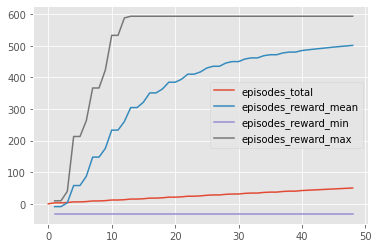

In [12]:
episodes_this_iter = df['episodes_this_iter']
episodes_total = df['episodes_total']
episodes_reward_mean = df['episode_reward_mean']
episodes_reward_max = df['episode_reward_max']
episodes_reward_min = df['episode_reward_min']

df_episodes = pd.DataFrame(episodes_total)
df_episodes['episodes_reward_mean'] = df['episode_reward_mean']
df_episodes["episodes_reward_min"] = df['episode_reward_min']
df_episodes["episodes_reward_max"] = df['episode_reward_max']

df_episodes.plot.line()

In [13]:
import ray.rllib.agents.dqn as dqn


checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(('episode_reward_mean'), mode='max'))

checkpoint_path = checkpoints[0][0]

# Restore agent
agent = dqn.DQNTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 0.01, #8e-6
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        'simple_optimizer': False
    }
)

agent.restore(checkpoint_path)

2021-12-17 18:51:50,159	WARNING deprecation.py:45 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2021-12-17 18:51:50,160	INFO dqn.py:141 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=3991) 2021-12-17 18:51:51,142	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=3991) 2021-12-17 18:51:51,171	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
(RolloutWorker pid=3991) 2021-12-17 18:51:51,177	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f41d084f1f0>: Box([[-inf -inf -inf -inf -inf]
(RolloutWorker pid=3991)  [-inf -inf -inf -inf -inf]
(RolloutWorker pid=3991)  [-inf -inf -inf -inf -inf]
(RolloutWorker pid=3991)  [-inf -inf -inf -inf -inf]
(RolloutWorker pid=3991)  [-inf -inf -inf -in

2021-12-17 18:51:51,311	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
2021-12-17 18:51:51,319	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2021-12-17 18:51:51,325	INFO rollout_worker.py:1555 -- Built policy map: {}
2021-12-17 18:51:51,326	INFO rollout_worker.py:1556 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f86d5ac5fd0>}
2021-12-17 18:51:51,327	INFO rollout_worker.py:618 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-12-17 18:51:51,328	DEBUG rollout_worker.py:728 -- Created rollout worker with env None (None), policies {}
2021-12-17 18:51:51,454	INFO trainable.py:467 -- Restored on 10.0.54.160 from checkpoint: /domino/datasets/local/Ray_Qui

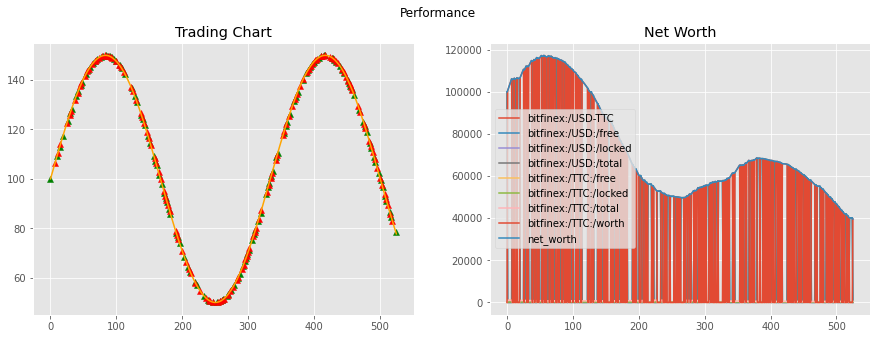

In [14]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 10
done = False
obs = env.reset()

while not done:
    #action = agent.compute_action(obs)
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()